داده‌های استفاده شده در این پروژه شامل فایل housePrice.csv است.

این داده‌ها شامل اطلاعات مربوط به خانه‌ها از جمله ویژگی‌هایی مانند متراژ، تعداد اتاق‌ها، وجود پارکینگ، انباری، و آسانسور و همچنین قیمت می‌باشد.


این پروژه شامل مدل‌های زیر است:

رگرسیون خطی: یک مدل خطی ساده که برای مقایسه اولیه استفاده می‌شود.


جنگل تصادفی: یک مدل تجمیعی که با میانگین‌گیری از چندین درخت تصمیم، دقت را بهبود می‌بخشد.


XGBoost: یک مدل بهینه‌سازی شده گرادیانت بوستینگ که عملکرد و سرعت بالایی را فراهم می‌کند.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [23]:
# 1. خواندن و پیش‌پردازش داده‌ها
df = pd.read_csv('housePrice.csv')

In [24]:
# حذف داده‌های نامعتبر
df = df.dropna(subset=['Address'])
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df = df.dropna(subset=['Area'])
df = df[df['Area'] <= 1000]

In [25]:
# تبدیل متغیرهای کیفی
for col in ['Parking', 'Warehouse', 'Elevator']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

In [26]:
# 2. Feature Engineering جدید
df['Price_per_sqm'] = df['Price'] / df['Area']  # قیمت هر متر مربع
df['Total_amenities'] = df['Parking'] + df['Warehouse'] + df['Elevator']  # مجموع امکانات
df['Room_to_area_ratio'] = df['Room'] / df['Area']  # نسبت اتاق به متراژ

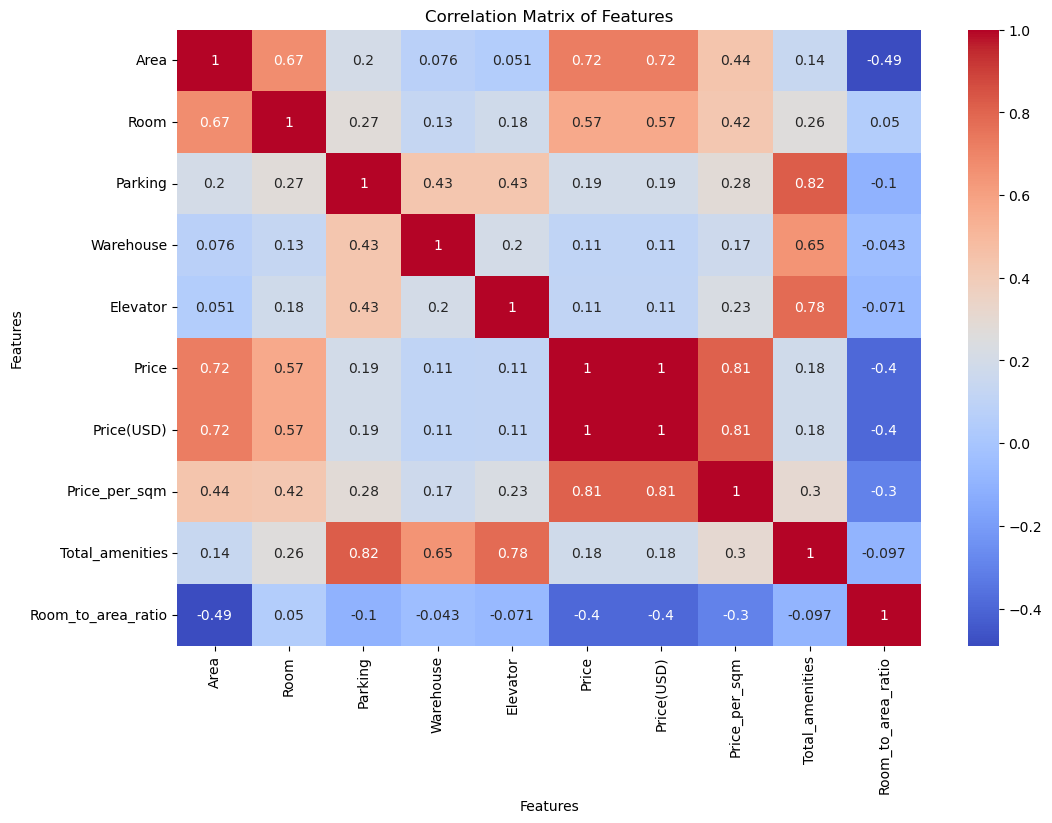

In [27]:
# 3. تحلیل اکتشافی پیشرفته (EDA)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')  
plt.xlabel('Features')  
plt.ylabel('Features')  
plt.show()

In [28]:
# 4. آماده‌سازی داده‌ها
X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 
        'Price_per_sqm', 'Total_amenities', 'Room_to_area_ratio']]
y = df['Price']

# استانداردسازی داده‌های عددی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [29]:
# 5. مدل‌سازی و مقایسه
# الف) رگرسیون خطی
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# ب) رندوم فارست
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_grid = GridSearchCV(rf, rf_params, cv=5)
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.predict(X_test)

# ج) XGBoost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5)
xgb_grid.fit(X_train, y_train)
xgb_pred = xgb_grid.predict(X_test)

In [30]:
# 6. ارزیابی مدل‌ها
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return pd.DataFrame({
        'Model': [name],
        'R2-Score': [r2],
        'MAE': [mae],
        'RMSE': [rmse]
    })

results = pd.concat([
    evaluate_model('Linear Regression', y_test, lr_pred),
    evaluate_model('Random Forest', y_test, rf_pred),
    evaluate_model('XGBoost', y_test, xgb_pred)
])

print("نتایج مقایسه مدل‌ها:")
print(results)

نتایج مقایسه مدل‌ها:
               Model  R2-Score           MAE          RMSE
0  Linear Regression  0.850839  1.609297e+09  3.359324e+09
0      Random Forest  0.974603  2.575107e+08  1.386166e+09
0            XGBoost  0.986392  2.117723e+08  1.014643e+09


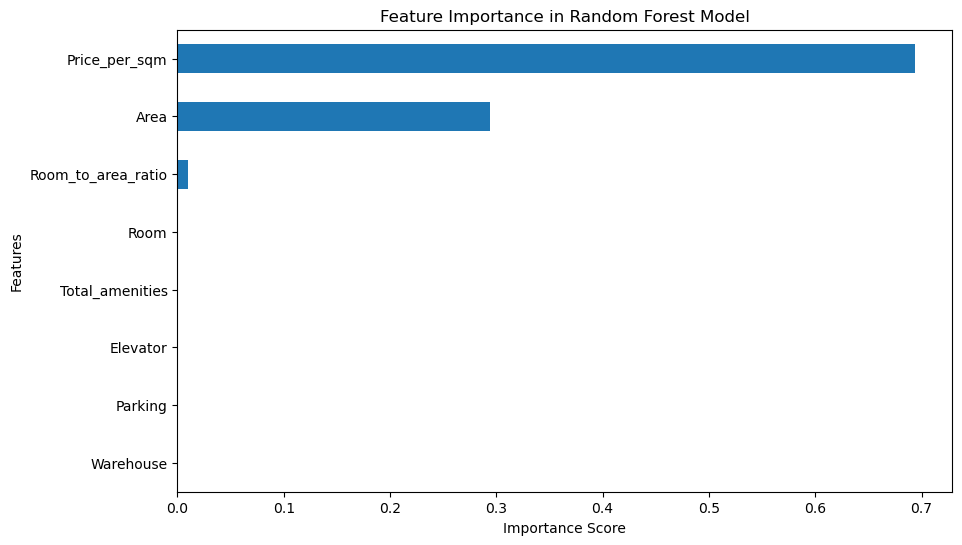

In [31]:
# 7. تحلیل اهمیت ویژگی‌ها در بهترین مدل
plt.figure(figsize=(10, 6))
feature_imp = pd.Series(rf_grid.best_estimator_.feature_importances_, index=X.columns)
feature_imp.sort_values().plot(kind='barh')
plt.title('Feature Importance in Random Forest Model')  
plt.xlabel('Importance Score')  
plt.ylabel('Features')  
plt.show()

In [32]:
# 8. ذخیره مدل برتر

import joblib
joblib.dump(rf_grid.best_estimator_, 'best_house_price_model.pkl')

['best_house_price_model.pkl']